<a href="https://colab.research.google.com/github/yeonghun00/stock-notes/blob/main/analysis/vesicek%20model%20on%20stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -U finance-datareader

'data_source' and 'exchange' argument deprecated, use in symbol like these:
  fdr.DataReader('FRED:DEXKOUS', '1990-01-01')
  fdr.DataReader('FRED:DEXKOUS')
  fdr.DataReader('FRED:NASDAQCOM,M2,HSN1F')
  
  fdr.DataReader('TSE:9984', '2020-01-01')
  fdr.DataReader('NYSE:CBOE', '1990-01-01')
  fdr.DataReader('SSE:000150', '1990-01-01')



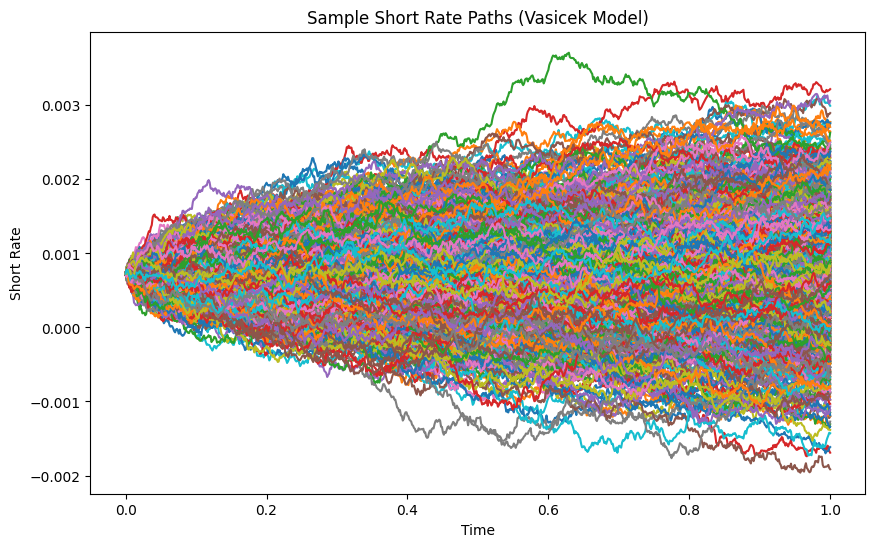

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import FinanceDataReader as fdr

# Fetch historical stock price data
ticker = 'AAPL'  # Example stock ticker (Apple Inc.)
start_date = '2020-01-01'
end_date = '2023-01-01'
stock_data = fdr.DataReader(ticker, data_source='yahoo', start=start_date, end=end_date)

# Extract daily closing prices
closing_prices = stock_data['Close'].values

# Calculate daily returns
daily_returns = np.diff(np.log(closing_prices))

# Parameters for the Vasicek model
r0 = daily_returns.mean()  # Initial short rate (mean of daily returns)
kappa = 0.1  # Mean reversion rate
theta = r0  # Long-term mean of the short rate (assumed to be the mean of daily returns)
sigma = daily_returns.std()  # Volatility

# Time horizon and number of time steps
T = 1  # Time horizon (1 year)
N = len(daily_returns)  # Number of time steps

# Function to simulate short rate using Vasicek model
def vasicek_short_rate(r0, kappa, theta, sigma, T, N, m):
    dt = T / N
    r = np.zeros((m, N+1))
    r[:, 0] = r0

    for i in range(m):
        for t in range(1, N+1):
            dW = np.random.normal(0, np.sqrt(dt))
            r[i, t] = r[i, t-1] + kappa * (theta - r[i, t-1]) * dt + sigma * np.sqrt(dt) * dW

    return r

# Number of Monte Carlo simulations
m = 1000

# Simulate short rate paths
short_rate_paths = vasicek_short_rate(r0, kappa, theta, sigma, T, N, m)

# Plot some sample short rate paths
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(0, T, N+1), short_rate_paths.T)
plt.xlabel('Time')
plt.ylabel('Short Rate')
plt.title('Sample Short Rate Paths (Vasicek Model)')
plt.show()


In [57]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_squared_error
import FinanceDataReader as fdr

# Fetch historical S&P 500 moving average data
sp500_data_ma = fdr.DataReader('S&P500', start='1980-01-01', end='2023-01-01')['Adj Close'].rolling(window=120).mean().dropna()

# Fetch other economic data (money supply, interest rate, GDP growth)
money_supply_data = fdr.DataReader('FRED:WM2NS', start='1980-01-01', end='2023-01-01')  # Money supply (M2)
interest_rate_data = fdr.DataReader('FRED:FEDFUNDS', start='1980-01-01', end='2023-01-01')  # Federal Funds Rate
gdp_growth_data = fdr.DataReader('FRED:A191RL1Q225SBEA', start='1980-01-01', end='202-01-01')  # Real GDP Growth Rate

# Combine all data into a single DataFrame
data = pd.concat([sp500_data_ma, money_supply_data, interest_rate_data, gdp_growth_data], axis=1)
data = data.ffill()

# Rename columns
data.columns = ['S&P 500 MA', 'Money Supply', 'Interest Rate', 'GDP Growth']

# Drop rows with missing values
data.dropna(inplace=True)

# Define features and target variable
X = data[['Money Supply', 'Interest Rate', 'GDP Growth']]  # Features: Money Supply, Interest Rate, GDP Growth
y = data['S&P 500 MA']  # Target Variable: S&P 500 Moving Average

# Normalize data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(np.array(y).reshape(-1, 1))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Define and compile the neural network model
model = Sequential()
model.add(Dense(50, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=72, validation_data=(X_test, y_test), verbose=2, shuffle=False)

# Make predictions
y_pred_scaled = model.predict(X_test)

# Invert scaling for predictions
y_pred = scaler.inverse_transform(y_pred_scaled)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred_scaled)
print(f'Mean Squared Error: {mse}')

OutOfBoundsDatetime: Out of bounds nanosecond timestamp: 202-01-01 00:00:00 present at position 0

In [56]:
# Normalize the input data using the same scaler
def normalize_input_data(input_data):
    input_data_scaled = scaler.transform(input_data)
    return input_data_scaled

# Invert scaling for predictions
def inverse_transform_predictions(predictions_scaled):
    predictions = scaler.inverse_transform(predictions_scaled)
    return predictions

# Predict S&P 500 moving average based on user input
def predict_sp500_moving_average(money_supply, interest_rate, gdp_growth):
    # Normalize input data
    money_supply_scaled = scaler.transform([[money_supply]])
    interest_rate_scaled = scaler.transform([[interest_rate]])
    gdp_growth_scaled = scaler.transform([[gdp_growth]])

    # Combine scaled features
    input_data_scaled = np.hstack((money_supply_scaled, interest_rate_scaled, gdp_growth_scaled))

    # Make predictions
    predictions_scaled = model.predict(input_data_scaled)

    # Invert scaling to get actual predicted values
    predictions = inverse_transform_predictions(predictions_scaled)

    return predictions

# Example usage:
money_supply = float(input("Enter Money Supply: "))
interest_rate = float(input("Enter Interest Rate: "))
gdp_growth = float(input("Enter GDP Growth: "))

predicted_sp500_ma = predict_sp500_moving_average(money_supply, interest_rate, gdp_growth)
print("Predicted S&P 500 Moving Average:", predicted_sp500_ma)


Enter Money Supply: 5000
Enter Interest Rate: 12
Enter GDP Growth: 5


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


ValueError: X has 1 features, but MinMaxScaler is expecting 3 features as input.

In [47]:
data

,S&P 500 MA,Money Supply,Interest Rate,GDP Growth
2000-06-22,1432.469498,4762.5,6.53,7.5
2000-06-23,1432.354998,4762.5,6.53,7.5
2000-06-26,1432.820748,4721.5,6.53,7.5
2000-06-27,1433.224415,4721.5,6.53,7.5
2000-06-28,1433.652498,4721.5,6.53,7.5
...,...,...,...,...
2021-12-28,4512.365487,21741.8,0.08,7.0
2021-12-29,4515.894739,21741.8,0.08,7.0
2021-12-30,4519.178906,21741.8,0.08,7.0
2021-12-31,4522.486991,21741.8,0.08,7.0


In [2]:
import FinanceDataReader as fdr
import pandas as pd
from datetime import datetime, timedelta

# Install finance-datareader if you haven't already
# !pip install -U finance-datareader

# Get all NYSE and NASDAQ tickers
nyse_tickers = fdr.StockListing('NYSE')
nasdaq_tickers = fdr.StockListing('NASDAQ')




100%|██████████| 3852/3852 [00:27<00:00, 138.45it/s]
/usr/local/lib/python3.10/dist-packages/FinanceDataReader/naver/listing.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged.rename(columns=ren_cols, inplace=True)


In [3]:
import FinanceDataReader as fdr


In [5]:
fdr.DataReader('aapl', '20201211')

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-12-11,122.430000,122.760002,120.550003,122.410004,120.132347,86939800
2020-12-14,122.599998,123.349998,121.540001,121.779999,119.514076,79184500
2020-12-15,124.339996,127.900002,124.129997,127.879997,125.500565,157243700
2020-12-16,127.410004,128.369995,126.559998,127.809998,125.431877,98208600
2020-12-17,128.899994,129.580002,128.039993,128.699997,126.305313,94359800
...,...,...,...,...,...,...
2024-02-26,182.240005,182.759995,180.649994,181.160004,181.160004,40867400
2024-02-27,181.100006,183.919998,179.559998,182.630005,182.630005,54318900
2024-02-28,182.509995,183.119995,180.130005,181.419998,181.419998,48953900


In [2]:
import FinanceDataReader as fdr
import pandas as pd
from datetime import datetime, timedelta
from multiprocessing import Pool, cpu_count

# Combine the lists of tickers
all_tickers = fdr.StockListing('NASDAQ')

# Define start and end dates for the data retrieval
end_date = datetime.now()
start_date = end_date - timedelta(days=365)

# Function to fetch data for a single ticker
def fetch_data(ticker):
    try:
        data = fdr.DataReader(ticker, start_date, end_date)
        data['Symbol'] = ticker
        return data
    except:
        return pd.DataFrame()

# Function to parallelize the data fetching process
def parallel_fetch(tickers):
    with Pool(cpu_count()) as pool:
        data = pool.map(fetch_data, tickers)
    return pd.concat(data)

# Split all_tickers into chunks for parallel processing
chunk_size = 100
ticker_chunks = [all_tickers[i:i+chunk_size] for i in range(0, len(all_tickers), chunk_size)]

# Fetch data for all tickers in parallel
all_data = pd.concat(parallel_fetch(chunk) for chunk in ticker_chunks)

# Reset the index of the DataFrame
all_data.reset_index(inplace=True)

# Print the first few rows of the DataFrame
print(all_data.head())

# Save the data to a CSV file if needed
# all_data.to_csv('stock_data.csv', index=False)


100%|██████████| 3852/3852 [00:27<00:00, 137.61it/s]


HTTP Error 404: Not Found  - symbol "SYMBOL" not found or invalid periods
HTTP Error 404: Not Found  - symbol "NAME" not found or invalid periods
HTTP Error 404: Not Found  - symbol "INDUSTRYCODE" not found or invalid periods
HTTP Error 404: Not Found  - symbol "INDUSTRY" not found or invalid periods


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "<ipython-input-2-756db1140e3a>", line 25, in parallel_fetch
    data = pool.map(fetch_data, tickers)
  File "/usr/lib/python3.10/multiprocessing/pool.py", line 367, in map
    return self._map_async(func, iterable, mapstar, chunksize).get()
  File "/usr/lib/python3.10/multiprocessing/pool.py", line 768, in get
    self.wait(timeout)
  File "/usr/lib/python3.10/multiprocessing/pool.py", line 765, in wait
    self._event.wait(timeout)
  File "/usr/lib/python3.10/threading.py", line 607, in wait
    signaled = self._cond.wait(timeout)
  File "/usr/lib/python3.10/threading.py", line 320, in wait
    waiter.acquire()
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-2-756db1140e3a>", line 33, in <

TypeError: object of type 'NoneType' has no len()

In [ ]:
how to ti